## Importing libraries

In [7]:
import scanpy as sc
import pandas as pd
import numpy as np
import scvi

/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading data

In [2]:
adata = sc.read_10x_mtx(path='/Users/yashasappaji/Desktop/projects/single_cell/Datasets/GSE245373_RAW/GSM7841477_P1', prefix='GSM7841477_P1_')
adata

AnnData object with n_obs × n_vars = 435 × 33538
    var: 'gene_ids', 'feature_types'

In [3]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=True, flavor='seurat_v3')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## Doublet Removal

In [4]:
import scvi.model

scvi.model.SCVI.setup_anndata(adata)
vae = scvi.model.SCVI(adata)
vae.train()

/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:116: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to im

Epoch 400/400: 100%|██████████| 400/400 [00:20<00:00, 20.25it/s, v_num=1, train_loss_step=553, train_loss_epoch=568]    

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [00:20<00:00, 19.52it/s, v_num=1, train_loss_step=553, train_loss_epoch=568]


In [5]:
solo = scvi.external.SOLO.from_scvi_model(vae)
solo.train()

INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:116: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to im

Epoch 161/400:  40%|████      | 161/400 [00:02<00:02, 80.15it/s, v_num=1, train_loss_step=0.256, train_loss_epoch=0.305]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.294. Signaling Trainer to stop.


In [6]:
df = solo.predict()
df['prediction'] = solo.predict(soft=False)

df

/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)


,doublet,singlet,prediction
AAACCTGGTAGCCTAT-1,0.510605,0.489395,doublet
AAAGATGCATTGGCGC-1,0.424240,0.575760,singlet
AAAGCAATCCCAGGTG-1,0.007119,0.992881,singlet
AAAGTAGAGATATGCA-1,0.122850,0.877150,singlet
AAAGTAGGTACTTCTT-1,0.180047,0.819953,singlet
...,...,...,...
TTTACTGGTGTGACGA-1,0.337914,0.662086,singlet
TTTCCTCCAGGACGTA-1,0.403346,0.596654,singlet
TTTGTCAAGATGTCGG-1,0.253645,0.746355,singlet
TTTGTCAAGCAGGCTA-1,0.040154,0.959846,singlet


In [7]:
df.groupby('prediction').count()

,doublet,singlet
prediction,,
doublet,104,104
singlet,331,331


In [8]:
df['dif'] = df.doublet - df.singlet
df

,doublet,singlet,prediction,dif
AAACCTGGTAGCCTAT-1,0.510605,0.489395,doublet,0.021209
AAAGATGCATTGGCGC-1,0.424240,0.575760,singlet,-0.151520
AAAGCAATCCCAGGTG-1,0.007119,0.992881,singlet,-0.985762
AAAGTAGAGATATGCA-1,0.122850,0.877150,singlet,-0.754300
AAAGTAGGTACTTCTT-1,0.180047,0.819953,singlet,-0.639906
...,...,...,...,...
TTTACTGGTGTGACGA-1,0.337914,0.662086,singlet,-0.324173
TTTCCTCCAGGACGTA-1,0.403346,0.596654,singlet,-0.193308
TTTGTCAAGATGTCGG-1,0.253645,0.746355,singlet,-0.492709
TTTGTCAAGCAGGCTA-1,0.040154,0.959846,singlet,-0.919691


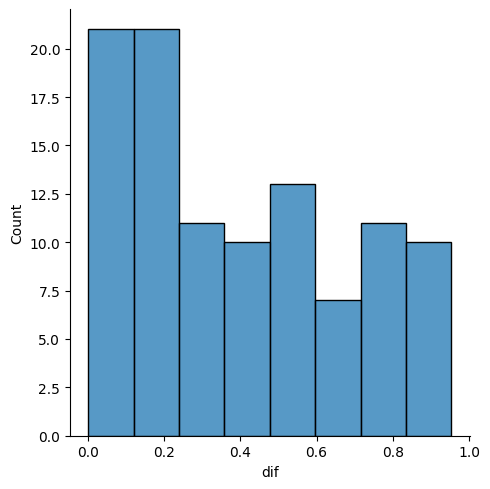

In [9]:
import seaborn as sns

sns.displot(df[df.prediction == 'doublet'], x = 'dif')

In [11]:
doublets = df[(df.prediction == 'doublet') & (df.dif > 0.7)]
doublets.shape

(21, 4)

In [12]:
adata = sc.read_10x_mtx(path='/Users/yashasappaji/Desktop/projects/single_cell/Datasets/GSE245373_RAW/GSM7841477_P1', prefix='GSM7841477_P1_')

adata.obs['doublet'] = adata.obs.index.isin(doublets.index)
adata = adata[~adata.obs.doublet]

adata

View of AnnData object with n_obs × n_vars = 414 × 33538
    obs: 'doublet'
    var: 'gene_ids', 'feature_types'

## Data preprocessing

In [13]:
adata.var['mt'] = adata.var.index.str.startswith('MT-')
adata.var

/var/folders/cc/zxztq5d10436scg1c7f92bkr0000gn/T/ipykernel_32278/3248256402.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['mt'] = adata.var.index.str.startswith('MT-')


,gene_ids,feature_types,mt
MIR1302-2HG,ENSG00000243485,Gene Expression,False
FAM138A,ENSG00000237613,Gene Expression,False
OR4F5,ENSG00000186092,Gene Expression,False
AL627309.1,ENSG00000238009,Gene Expression,False
AL627309.3,ENSG00000239945,Gene Expression,False
...,...,...,...
AC233755.2,ENSG00000277856,Gene Expression,False
AC233755.1,ENSG00000275063,Gene Expression,False
AC240274.1,ENSG00000271254,Gene Expression,False
AC213203.1,ENSG00000277475,Gene Expression,False


In [14]:
ribo_path = "/Users/yashasappaji/Desktop/projects/single_cell/Datasets/KEGG_RIBOSOME.v2023.2.Hs.txt"
ribo_genes = pd.read_table(ribo_path, skiprows=2, header=None)
adata.var['ribo'] = adata.var_names.isin(ribo_genes[0].values)

In [15]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo'], percent_top=None, log1p=False, inplace=True)

In [16]:
adata.obs

,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo
AAACCTGGTAGCCTAT-1,False,1909,4396.0,436.0,9.918107,793.0,18.039127
AAAGATGCATTGGCGC-1,False,1481,5127.0,386.0,7.528769,1737.0,33.879463
AAAGCAATCCCAGGTG-1,False,1304,3622.0,242.0,6.681392,1288.0,35.560463
AAAGTAGAGATATGCA-1,False,1493,4560.0,245.0,5.372807,1511.0,33.135967
AAAGTAGGTACTTCTT-1,False,22,800.0,0.0,0.000000,3.0,0.375000
...,...,...,...,...,...,...,...
TTTACTGCAGCGTAAG-1,False,1058,2629.0,106.0,4.031951,621.0,23.621149
TTTACTGGTGTGACGA-1,False,2139,5961.0,187.0,3.137058,888.0,14.896830
TTTCCTCCAGGACGTA-1,False,1708,4752.0,131.0,2.756734,1356.0,28.535355
TTTGTCAAGATGTCGG-1,False,1390,4010.0,111.0,2.768080,1274.0,31.770575


In [17]:
adata.var.sort_values('n_cells_by_counts')

,gene_ids,feature_types,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
MIR1302-2HG,ENSG00000243485,Gene Expression,False,False,0,0.000000,100.000000,0.0
AL121748.2,ENSG00000238258,Gene Expression,False,False,0,0.000000,100.000000,0.0
AL391839.1,ENSG00000229327,Gene Expression,False,False,0,0.000000,100.000000,0.0
AL158834.1,ENSG00000226842,Gene Expression,False,False,0,0.000000,100.000000,0.0
AL158834.2,ENSG00000227253,Gene Expression,False,False,0,0.000000,100.000000,0.0
...,...,...,...,...,...,...,...,...
RPL41,ENSG00000229117,Gene Expression,False,True,406,48.152172,1.932367,19935.0
EEF1A1,ENSG00000156508,Gene Expression,False,False,406,55.758453,1.932367,23084.0
B2M,ENSG00000166710,Gene Expression,False,False,407,62.173912,1.690821,25740.0
MT-CO1,ENSG00000198804,Gene Expression,True,False,408,39.524155,1.449275,16363.0


In [18]:
sc.pp.filter_genes(adata, min_cells=3)
adata.var.sort_values('n_cells_by_counts')

,gene_ids,feature_types,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells
B3GAT2,ENSG00000112309,Gene Expression,False,False,3,0.007246,99.275362,3.0,3
AL357033.4,ENSG00000277496,Gene Expression,False,False,3,0.007246,99.275362,3.0,3
ENPP5,ENSG00000112796,Gene Expression,False,False,3,0.007246,99.275362,3.0,3
MFSD4A,ENSG00000174514,Gene Expression,False,False,3,0.007246,99.275362,3.0,3
AL096865.1,ENSG00000271857,Gene Expression,False,False,3,0.007246,99.275362,3.0,3
...,...,...,...,...,...,...,...,...,...
RPL41,ENSG00000229117,Gene Expression,False,True,406,48.152172,1.932367,19935.0,406
EEF1A1,ENSG00000156508,Gene Expression,False,False,406,55.758453,1.932367,23084.0,406
B2M,ENSG00000166710,Gene Expression,False,False,407,62.173912,1.690821,25740.0,407
MT-CO1,ENSG00000198804,Gene Expression,True,False,408,39.524155,1.449275,16363.0,408


In [19]:
adata.obs.sort_values('n_genes_by_counts')

,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo
GGATGTTCAGACGCAA-1,False,13,526.0,377.0,71.673004,0.0,0.000000
CTACATTGTACAGTGG-1,False,15,503.0,311.0,61.829025,0.0,0.000000
CTGTGCTAGGTGGGTT-1,False,19,1052.0,651.0,61.882126,0.0,0.000000
GATGAGGGTCATACTG-1,False,19,1010.0,738.0,73.069305,1.0,0.099010
AAAGTAGGTACTTCTT-1,False,22,800.0,0.0,0.000000,3.0,0.375000
...,...,...,...,...,...,...,...
ACCAGTAAGGGCATGT-1,False,2910,13425.0,522.0,3.888268,2950.0,21.973928
AGCGTATGTACCGAGA-1,False,2941,10003.0,296.0,2.959112,2548.0,25.472359
ACACTGATCACGATGT-1,False,3072,12639.0,632.0,5.000396,1879.0,14.866683
ATCTACTGTTAAGGGC-1,False,3149,18019.0,653.0,3.623952,3586.0,19.901217


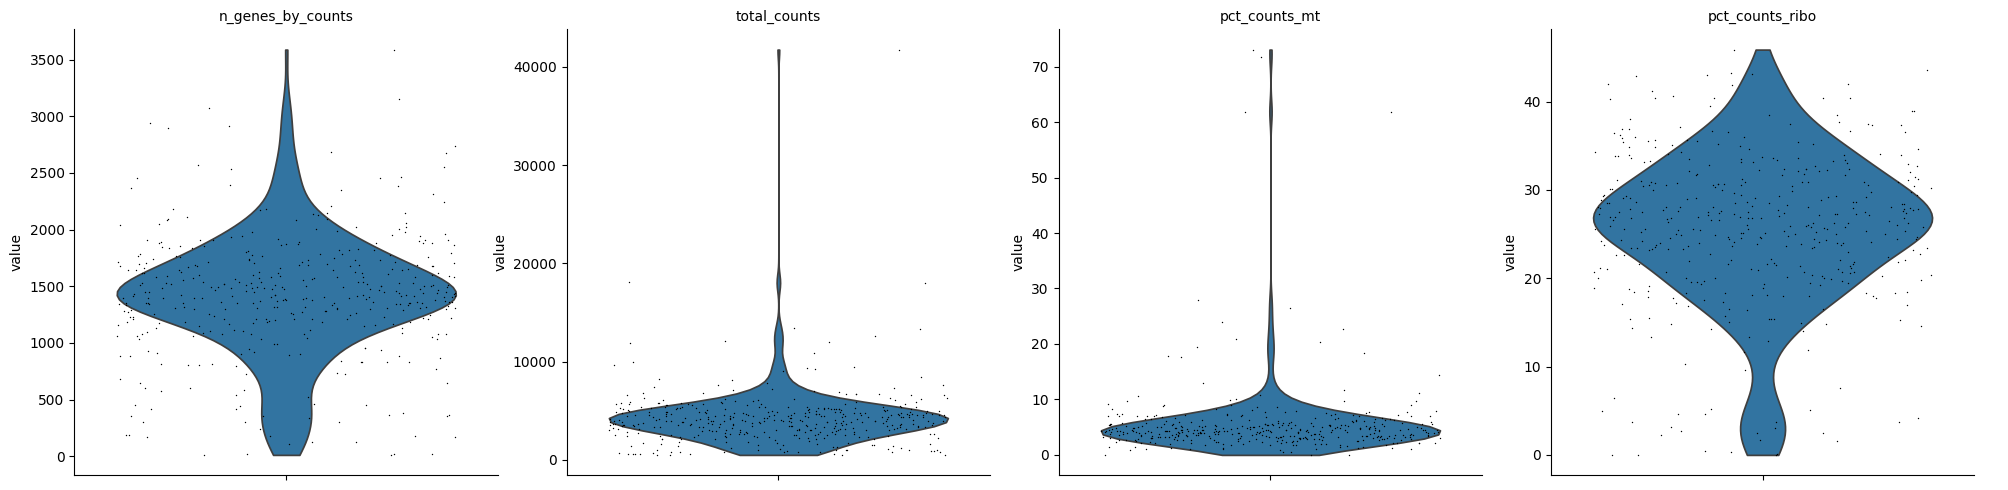

In [20]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'], 
             jitter=0.4, multi_panel=True)

In [21]:
upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, .98)
adata = adata[adata.obs.n_genes_by_counts < upper_lim]
adata.obs

,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo
AAACCTGGTAGCCTAT-1,False,1909,4396.0,436.0,9.918107,793.0,18.039127
AAAGATGCATTGGCGC-1,False,1481,5127.0,386.0,7.528769,1737.0,33.879463
AAAGCAATCCCAGGTG-1,False,1304,3622.0,242.0,6.681392,1288.0,35.560463
AAAGTAGAGATATGCA-1,False,1493,4560.0,245.0,5.372807,1511.0,33.135967
AAAGTAGGTACTTCTT-1,False,22,800.0,0.0,0.000000,3.0,0.375000
...,...,...,...,...,...,...,...
TTTACTGCAGCGTAAG-1,False,1058,2629.0,106.0,4.031951,621.0,23.621149
TTTACTGGTGTGACGA-1,False,2139,5961.0,187.0,3.137058,888.0,14.896830
TTTCCTCCAGGACGTA-1,False,1708,4752.0,131.0,2.756734,1356.0,28.535355
TTTGTCAAGATGTCGG-1,False,1390,4010.0,111.0,2.768080,1274.0,31.770575


## Normalization

In [22]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata

/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


## Clustering

In [23]:
sc.pp.highly_variable_genes(adata, n_top_genes = 2000)
adata.var

,gene_ids,feature_types,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells,highly_variable,means,dispersions,dispersions_norm
AL669831.5,ENSG00000237491,Gene Expression,False,False,19,0.045894,95.410628,19.0,19,False,0.135516,1.241507,0.069076
LINC00115,ENSG00000225880,Gene Expression,False,False,10,0.024155,97.584541,10.0,10,True,0.081360,1.645819,0.955548
FAM41C,ENSG00000230368,Gene Expression,False,False,7,0.016908,98.309179,7.0,7,False,0.036427,0.827823,-0.837943
NOC2L,ENSG00000188976,Gene Expression,False,False,48,0.120773,88.405797,50.0,48,False,0.271397,1.340884,0.286964
KLHL17,ENSG00000187961,Gene Expression,False,False,3,0.007246,99.275362,3.0,3,False,0.016547,1.450422,0.527133
...,...,...,...,...,...,...,...,...,...,...,...,...,...
MT-CYB,ENSG00000198727,Gene Expression,True,False,405,16.618357,2.173913,6880.0,405,True,3.904507,4.395600,1.779922
AC145212.1,ENSG00000277400,Gene Expression,False,False,3,0.007246,99.275362,3.0,3,False,0.016494,0.835116,-0.821954
MAFIP,ENSG00000274847,Gene Expression,False,False,3,0.007246,99.275362,3.0,3,False,0.015058,0.823474,-0.847479
AC011043.1,ENSG00000276256,Gene Expression,False,False,7,0.016908,98.309179,7.0,7,True,0.052321,1.798595,1.290516


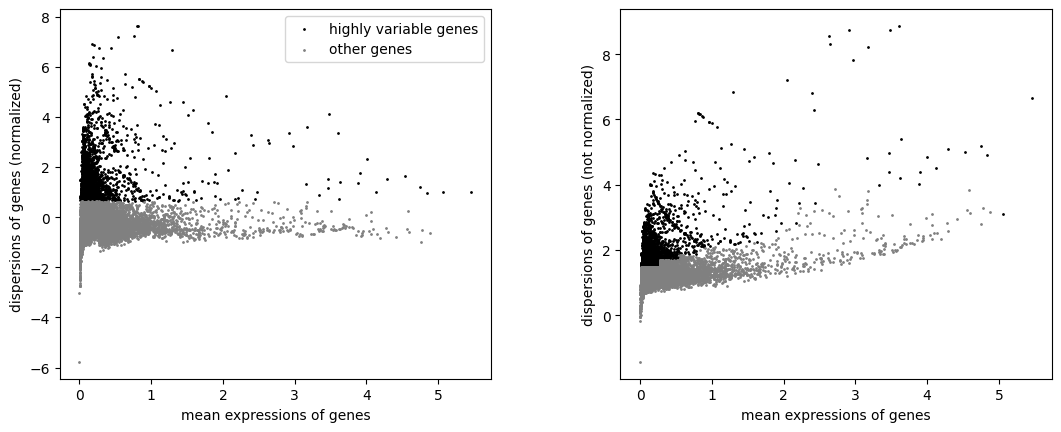

In [24]:
sc.pl.highly_variable_genes(adata)

In [25]:
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt', 'pct_counts_ribo'])

/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:657: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


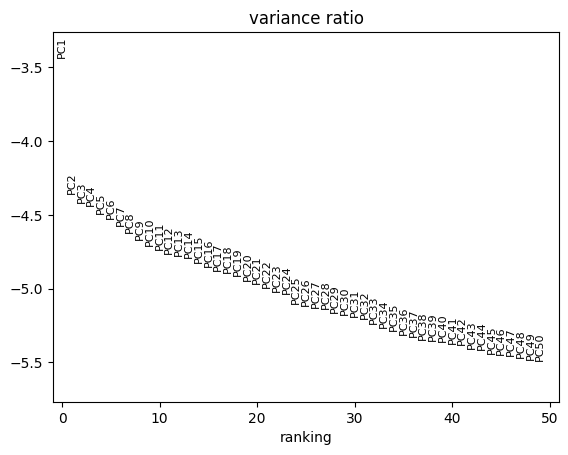

In [26]:
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True, n_pcs = 50)

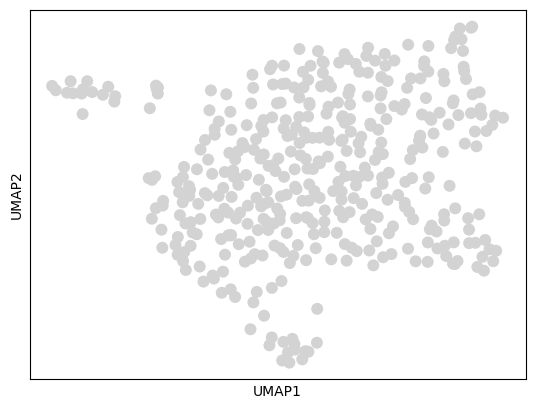

In [27]:
sc.pp.neighbors(adata, n_pcs = 20)
sc.tl.umap(adata)
sc.pl.umap(adata)

/var/folders/cc/zxztq5d10436scg1c7f92bkr0000gn/T/ipykernel_32278/3777065672.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution = 0.5)


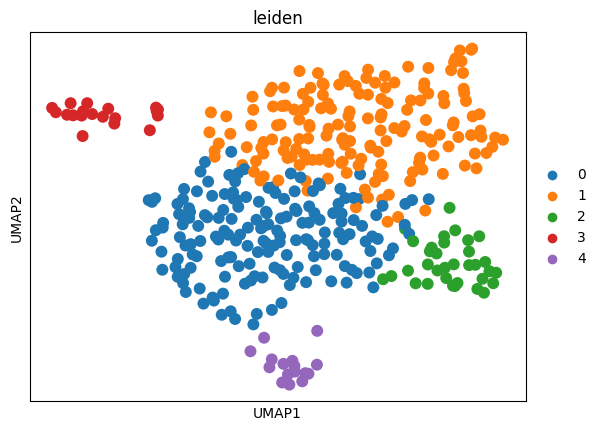

In [28]:
sc.tl.leiden(adata, resolution = 0.5)
sc.pl.umap(adata, color=['leiden'])

## Integration

In [32]:
os.listdir('/Users/yashasappaji/Desktop/projects/single_cell/Datasets/GSE245373_RAW')

['.DS_Store',
 'GSM7841477_P1',
 'GSM7841484_P8',
 'GSM7841486_advAp',
 'GSM7841482_P6',
 'GSM7841479_P3',
 'GSM7841483_P7',
 'GSM7841478_P2',
 'GSM7841480_P4',
 'GSM7841481_P5',
 'GSM7841485_bAPOE',
 'GSM7841487_advWt']

In [33]:
def integrate(data_path):
    pf = data_path.split('/')[-1]
    adata = sc.read_10x_mtx(path=data_path, prefix=pf+'_')
    
    sc.pp.highly_variable_genes(adata, n_top_genes = 2000, subset = True, flavor = 'seurat_v3')
    scvi.model.SCVI.setup_anndata(adata)
    vae = scvi.model.SCVI(adata)
    vae.train()
    solo = scvi.external.SOLO.from_scvi_model(vae)
    solo.train()
    df = solo.predict()
    df['prediction'] = solo.predict(soft = False)
    df.index = df.index.map(lambda x: x[:-2])
    df['dif'] = df.doublet - df.singlet
    doublets = df[(df.prediction == 'doublet') & (df.dif > 0.5)]
    
    adata = sc.read_10x_mtx(path=data_path, prefix=pf+'_')
    adata.obs['Sample'] = pf
    
    adata.obs['doublet'] = adata.obs.index.isin(doublets.index)
    adata = adata[~adata.obs.doublet]
    
    sc.pp.filter_genes(adata, min_cells=3)
    ribo_path = "/Users/yashasappaji/Desktop/projects/single_cell/Datasets/KEGG_RIBOSOME.v2023.2.Hs.txt"
    ribo_genes = pd.read_table(ribo_path, skiprows=2, header=None)
    
    adata.var['mt'] = adata.var_names.str.startswith('mt-')
    adata.var['ribo'] = adata.var_names.isin(ribo_genes[0].values)
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo'], percent_top=None, log1p=False, inplace=True)
    upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, .98)
    adata = adata[adata.obs.n_genes_by_counts < upper_lim]

    return adata

In [36]:
import os

out = []
for file in os.listdir('/Users/yashasappaji/Desktop/projects/single_cell/Datasets/GSE245373_RAW'):
    if file == '.DS_Store':
        continue
    out.append(integrate('/Users/yashasappaji/Desktop/projects/single_cell/Datasets/GSE245373_RAW/' + file))


/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:116: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to im

Epoch 400/400: 100%|██████████| 400/400 [00:23<00:00, 19.50it/s, v_num=1, train_loss_step=541, train_loss_epoch=569]    

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [00:23<00:00, 17.27it/s, v_num=1, train_loss_step=541, train_loss_epoch=569]
INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:116: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to im

Epoch 141/400:  35%|███▌      | 141/400 [00:01<00:03, 80.75it/s, v_num=1, train_loss_step=0.214, train_loss_epoch=0.326]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.307. Signaling Trainer to stop.


/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:282: ImplicitModificationWarning: Trying to

Epoch 400/400: 100%|██████████| 400/400 [03:43<00:00,  1.83it/s, v_num=1, train_loss_step=511, train_loss_epoch=464]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [03:43<00:00,  1.79it/s, v_num=1, train_loss_step=511, train_loss_epoch=464]
INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:116: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to im

Epoch 245/400:  61%|██████▏   | 245/400 [00:25<00:15,  9.77it/s, v_num=1, train_loss_step=0.413, train_loss_epoch=0.398]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.384. Signaling Trainer to stop.


/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:282: ImplicitModificationWarning: Trying to

Epoch 400/400: 100%|██████████| 400/400 [04:20<00:00,  1.59it/s, v_num=1, train_loss_step=406, train_loss_epoch=415]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [04:20<00:00,  1.54it/s, v_num=1, train_loss_step=406, train_loss_epoch=415]
INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:116: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to im

Epoch 206/400:  52%|█████▏    | 206/400 [00:24<00:22,  8.53it/s, v_num=1, train_loss_step=0.309, train_loss_epoch=0.263]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.250. Signaling Trainer to stop.


/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:282: ImplicitModificationWarning: Trying to

Epoch 400/400: 100%|██████████| 400/400 [00:34<00:00, 11.56it/s, v_num=1, train_loss_step=548, train_loss_epoch=528]    

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [00:34<00:00, 11.64it/s, v_num=1, train_loss_step=548, train_loss_epoch=528]
INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:116: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to im

Epoch 231/400:  58%|█████▊    | 231/400 [00:04<00:03, 53.97it/s, v_num=1, train_loss_step=0.414, train_loss_epoch=0.272]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.365. Signaling Trainer to stop.


/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:282: ImplicitModificationWarning: Trying to

Epoch 400/400: 100%|██████████| 400/400 [06:38<00:00,  1.03it/s, v_num=1, train_loss_step=358, train_loss_epoch=335]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [06:38<00:00,  1.00it/s, v_num=1, train_loss_step=358, train_loss_epoch=335]
INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:116: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to im

Epoch 174/400:  44%|████▎     | 174/400 [00:32<00:42,  5.31it/s, v_num=1, train_loss_step=0.294, train_loss_epoch=0.291]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.287. Signaling Trainer to stop.


/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:282: ImplicitModificationWarning: Trying to

Epoch 400/400: 100%|██████████| 400/400 [00:18<00:00, 21.00it/s, v_num=1, train_loss_step=413, train_loss_epoch=417]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [00:18<00:00, 21.14it/s, v_num=1, train_loss_step=413, train_loss_epoch=417]
INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:116: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to im

Epoch 279/400:  70%|██████▉   | 279/400 [00:03<00:01, 88.69it/s, v_num=1, train_loss_step=0.211, train_loss_epoch=0.295]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.351. Signaling Trainer to stop.


/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:282: ImplicitModificationWarning: Trying to

Epoch 400/400: 100%|██████████| 400/400 [00:25<00:00, 16.74it/s, v_num=1, train_loss_step=947, train_loss_epoch=863]      

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [00:25<00:00, 15.72it/s, v_num=1, train_loss_step=947, train_loss_epoch=863]
INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:116: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to im

Epoch 171/400:  43%|████▎     | 171/400 [00:02<00:03, 71.58it/s, v_num=1, train_loss_step=0.376, train_loss_epoch=0.359]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.397. Signaling Trainer to stop.


/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:282: ImplicitModificationWarning: Trying to

Epoch 400/400: 100%|██████████| 400/400 [07:36<00:00,  1.15s/it, v_num=1, train_loss_step=479, train_loss_epoch=457]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [07:36<00:00,  1.14s/it, v_num=1, train_loss_step=479, train_loss_epoch=457]
INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/scvi/external/solo/_model.py:216: RuntimeWarning: divide by zero encountered in log
  latent_adata = AnnData(np.concatenate([latent_rep, np.log(lib_size)], axis=1))
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:116: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-pac

Epoch 1/400:   0%|          | 1/400 [00:00<01:33,  4.25it/s, v_num=1, train_loss_step=nan, train_loss_epoch=nan]
Monitored metric validation_loss = nan is not finite. Previous best value was inf. Signaling Trainer to stop.


/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/scvi/external/solo/_model.py:443: FutureWarning: The behavior of DataFrame.

In [64]:
out

[View of AnnData object with n_obs × n_vars = 426 × 11852
     obs: 'Sample', 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
     var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts',
 View of AnnData object with n_obs × n_vars = 797 × 13247
     obs: 'Sample', 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
     var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts',
 View of AnnData object with n_obs × n_vars = 452 × 11013
     obs: 'Sample', 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
     var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by

In [37]:
adata = sc.concat(out)
adata

/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 36298 × 10279
    obs: 'Sample', 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'

In [40]:
adata.write_h5ad('/Users/yashasappaji/Desktop/projects/single_cell/Datasets/GSE245373.h5ad')

In [27]:
adata = sc.read_h5ad('/Users/yashasappaji/Desktop/projects/single_cell/Datasets/GSE245373.h5ad')
adata

/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 36298 × 10279
    obs: 'Sample', 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'n_cells'

In [28]:
adata.obs.groupby('Sample').count()

/var/folders/cc/zxztq5d10436scg1c7f92bkr0000gn/T/ipykernel_831/2340059915.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby('Sample').count()


,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo
Sample,,,,,,,
GSM7841477_P1,426,426,426,426,426,426,426
GSM7841478_P2,452,452,452,452,452,452,452
GSM7841479_P3,797,797,797,797,797,797,797
GSM7841480_P4,602,602,602,602,602,602,602
GSM7841481_P5,11951,11951,11951,11951,11951,11951,11951
GSM7841482_P6,6239,6239,6239,6239,6239,6239,6239
GSM7841483_P7,10402,10402,10402,10402,10402,10402,10402
GSM7841484_P8,5429,5429,5429,5429,5429,5429,5429


In [29]:
adata.layers['counts'] = adata.X.copy()

In [30]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.raw = adata

In [31]:
scvi.model.SCVI.setup_anndata(adata, layer="counts", categorical_covariate_keys=['Sample'], continuous_covariate_keys=['pct_counts_mt', 'total_counts', 'pct_counts_ribo'])

In [32]:
model = scvi.model.SCVI(adata)
model.train()

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 220/220: 100%|██████████| 220/220 [1:18:45<00:00, 21.30s/it, v_num=1, train_loss_step=4.97e+3, train_loss_epoch=4.52e+3]

`Trainer.fit` stopped: `max_epochs=220` reached.


Epoch 220/220: 100%|██████████| 220/220 [1:18:45<00:00, 21.48s/it, v_num=1, train_loss_step=4.97e+3, train_loss_epoch=4.52e+3]


In [33]:
model.get_latent_representation()

array([[ 1.0196512 ,  1.9102275 , -2.41526   , ..., -0.23121476,
        -0.3426054 , -1.3342447 ],
       [ 1.64271   ,  0.06887102, -1.6038275 , ...,  1.6236279 ,
         1.0516367 , -1.7086565 ],
       [-0.56713474,  1.149298  , -1.0881497 , ..., -1.1413198 ,
         0.89658177, -0.79772043],
       ...,
       [ 1.0564184 ,  1.3123181 ,  1.8540661 , ...,  1.3732975 ,
         1.27434   , -0.19274667],
       [ 0.7206723 , -0.47770593, -0.30011883, ...,  0.40857592,
        -1.3683643 , -1.2692306 ],
       [-2.2650301 , -0.5275508 , -0.5830339 , ..., -1.2836361 ,
         1.6099106 ,  0.01965976]], dtype=float32)

In [35]:
adata.obsm['X_scVI'] = model.get_latent_representation()
adata.layers['scvi_normalized'] = model.get_normalized_expression()

In [37]:
sc.pp.neighbors(adata, use_rep = 'X_scVI')
sc.tl.umap(adata)

In [38]:
for res in [0.02, 0.1, 0.3, 0.5, 0.8, 1.0]:
    sc.tl.leiden(adata, key_added=f"leiden_res_{res:4.2f}", resolution=res, flavor='igraph')

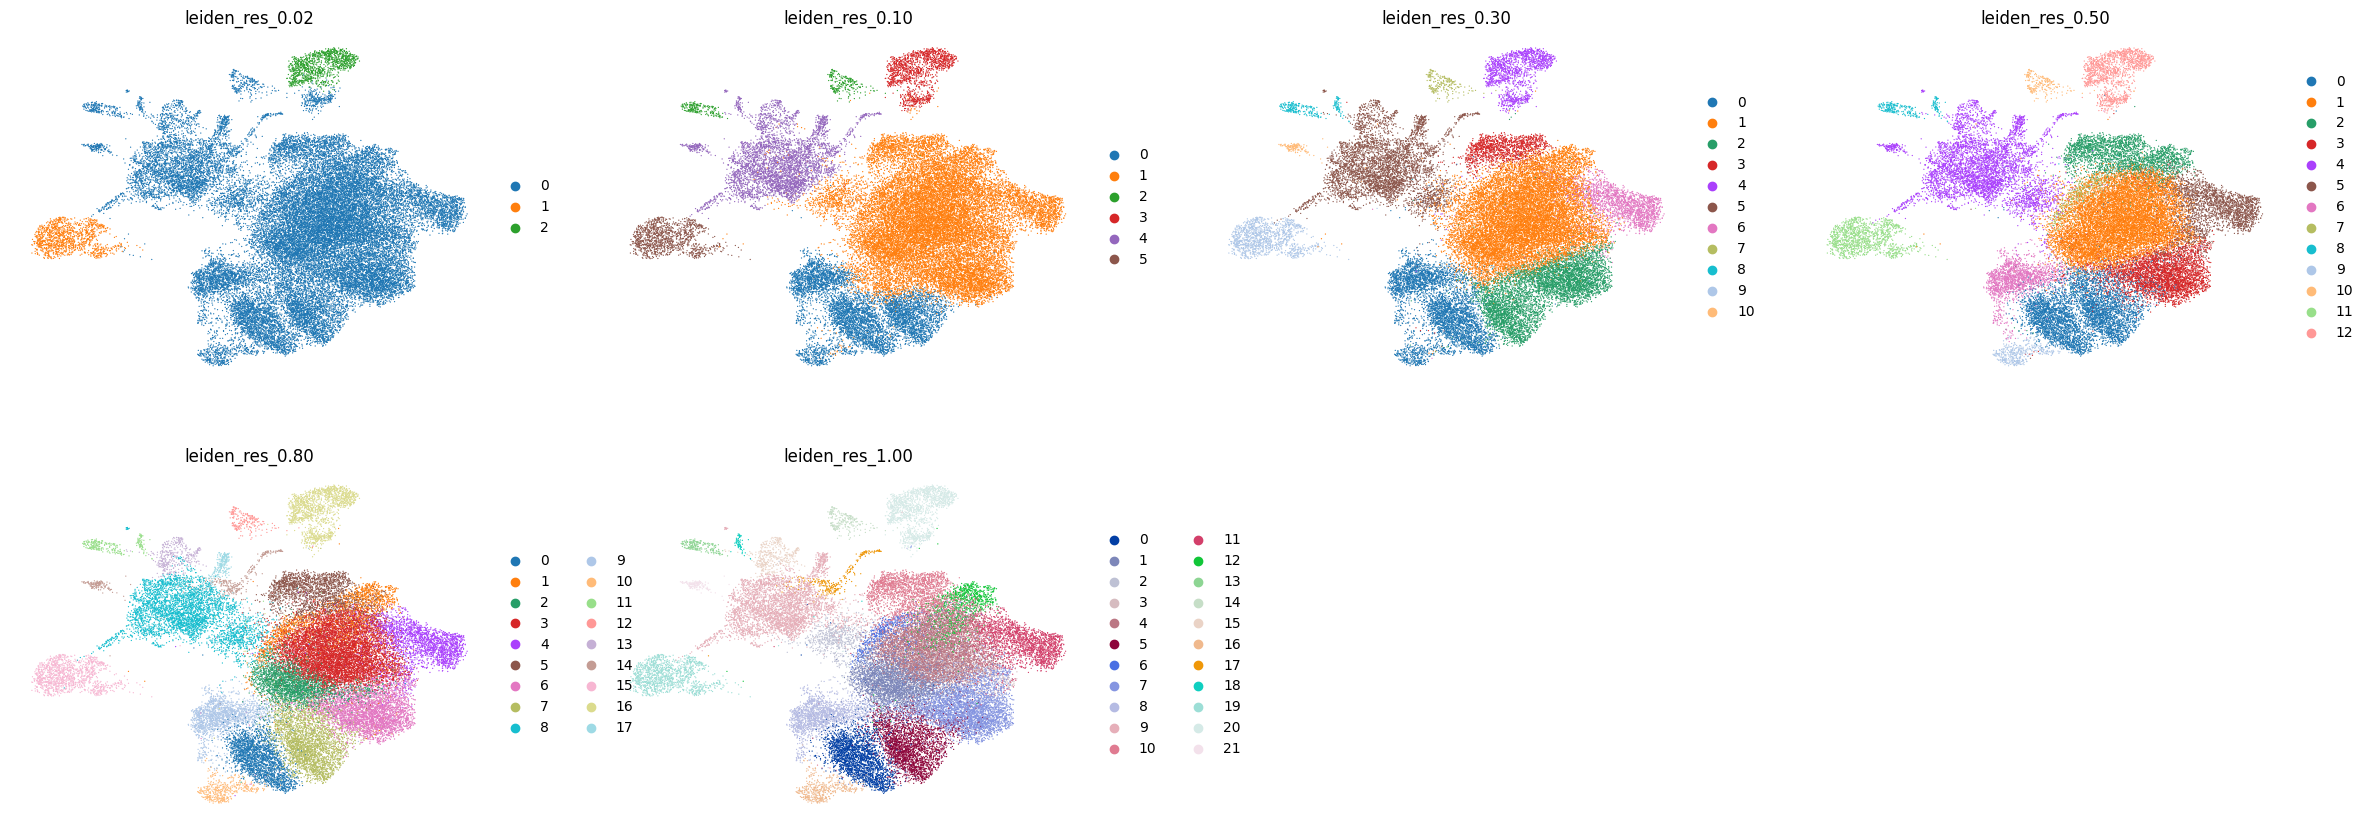

In [40]:
sc.pl.umap(adata, color = ['leiden_res_0.02', 'leiden_res_0.10', 'leiden_res_0.30', 'leiden_res_0.50', 'leiden_res_0.80', 'leiden_res_1.00'], frameon=False)

In [41]:
adata.write_h5ad('/Users/yashasappaji/Desktop/projects/single_cell/Datasets/GSE245373_integrated.h5ad')

## Cell Type Labeling

In [42]:
adata = sc.read_h5ad('/Users/yashasappaji/Desktop/projects/single_cell/Datasets/GSE245373_integrated.h5ad')

/Users/yashasappaji/Desktop/projects/single_cell/.venv/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [163]:
sc.tl.rank_genes_groups(adata, 'leiden_res_0.80')

In [165]:
markers = sc.get.rank_genes_groups_df(adata, group=None)
markers = markers[(markers['pvals_adj'] < 0.05) & (markers['logfoldchanges'] > 0.5)]
markers

,group,names,scores,logfoldchanges,pvals,pvals_adj
0,0,NKG7,185.481842,4.132245,0.000000,0.000000
1,0,GNLY,180.553680,5.413445,0.000000,0.000000
2,0,PRF1,138.061401,4.306966,0.000000,0.000000
3,0,GZMB,125.159935,4.243525,0.000000,0.000000
4,0,CST7,116.281036,2.850984,0.000000,0.000000
...,...,...,...,...,...,...
176771,17,TXNDC11,2.240885,0.523084,0.025819,0.048732
176772,17,CD40,2.240297,0.718347,0.025856,0.048784
176774,17,GOSR2,2.238577,0.584169,0.025972,0.048967
176777,17,HSDL1,2.230916,0.944323,0.026484,0.049868


In [167]:
markers_scvi = model.differential_expression(groupby='leiden_res_0.80')
markers_scvi

DE...: 100%|██████████| 18/18 [01:39<00:00,  5.50s/it]


,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
PRF1,0.9932,0.0068,4.984008,0.003268,0.000295,0.0,0.25,4.405812,4.623985,1.833935,...,11.478722,1.248442,0.982586,0.338725,33.991913,2.915527,True,0 vs Rest,0,Rest
SPON2,0.9926,0.0074,4.898846,0.000858,0.000049,0.0,0.25,4.794433,5.002225,1.812540,...,3.200273,0.170611,0.749238,0.079115,9.506449,0.344121,True,0 vs Rest,0,Rest
TTC38,0.9924,0.0076,4.871977,0.000207,0.000022,0.0,0.25,3.788295,3.919116,1.538972,...,0.742275,0.091848,0.473661,0.074733,2.230787,0.217841,True,0 vs Rest,0,Rest
FGFBP2,0.9916,0.0084,4.771087,0.001256,0.000121,0.0,0.25,4.347614,4.393353,2.064632,...,3.310417,0.243815,0.790596,0.075498,10.393429,0.551076,True,0 vs Rest,0,Rest
CD247,0.9886,0.0114,4.462676,0.001069,0.000234,0.0,0.25,2.414422,2.293604,1.175517,...,3.650427,0.847233,0.929473,0.434487,11.185285,2.112723,True,0 vs Rest,0,Rest
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PSMF1,0.4424,0.5576,-0.231427,0.000086,0.000082,0.0,0.25,0.109185,0.087847,0.412716,...,0.547101,0.368400,0.423913,0.290267,0.839402,0.857509,False,17 vs Rest,17,Rest
TRAPPC3,0.4248,0.5752,-0.303099,0.000052,0.000053,0.0,0.25,-0.005103,-0.030156,0.396507,...,0.384058,0.243546,0.307971,0.208095,0.591714,0.562390,False,17 vs Rest,17,Rest
RBM17,0.3904,0.6096,-0.445631,0.000085,0.000088,0.0,0.25,-0.029043,-0.036613,0.363037,...,0.583333,0.404510,0.431159,0.303287,0.897150,0.956145,False,17 vs Rest,17,Rest
UBE2D3,0.3682,0.6318,-0.539947,0.000283,0.000270,0.0,0.25,0.086323,0.065713,0.344238,...,1.891308,1.222163,0.771739,0.613014,2.895289,2.783457,False,17 vs Rest,17,Rest


In [168]:
markers_scvi = markers_scvi[(markers_scvi['is_de_fdr_0.05']) & (markers_scvi['lfc_mean'] > .5)]
markers_scvi

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
PRF1,0.9932,0.0068,4.984008,0.003268,0.000295,0.0,0.25,4.405812,4.623985,1.833935,...,11.478722,1.248442,0.982586,0.338725,33.991913,2.915527,True,0 vs Rest,0,Rest
SPON2,0.9926,0.0074,4.898846,0.000858,0.000049,0.0,0.25,4.794433,5.002225,1.812540,...,3.200273,0.170611,0.749238,0.079115,9.506449,0.344121,True,0 vs Rest,0,Rest
TTC38,0.9924,0.0076,4.871977,0.000207,0.000022,0.0,0.25,3.788295,3.919116,1.538972,...,0.742275,0.091848,0.473661,0.074733,2.230787,0.217841,True,0 vs Rest,0,Rest
FGFBP2,0.9916,0.0084,4.771087,0.001256,0.000121,0.0,0.25,4.347614,4.393353,2.064632,...,3.310417,0.243815,0.790596,0.075498,10.393429,0.551076,True,0 vs Rest,0,Rest
CD247,0.9886,0.0114,4.462676,0.001069,0.000234,0.0,0.25,2.414422,2.293604,1.175517,...,3.650427,0.847233,0.929473,0.434487,11.185285,2.112723,True,0 vs Rest,0,Rest
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CHN2,0.9194,0.0806,2.434223,0.000025,0.000012,0.0,0.25,1.310735,1.295399,1.241807,...,0.177536,0.041530,0.152174,0.038005,0.282938,0.102547,True,17 vs Rest,17,Rest
CCL4,0.9194,0.0806,2.434223,0.002061,0.003009,0.0,0.25,0.530306,0.351826,2.287011,...,9.119563,10.820610,0.471014,0.434068,13.377642,30.671598,True,17 vs Rest,17,Rest
SLC27A3,0.9190,0.0810,2.428837,0.000037,0.000017,0.0,0.25,1.387944,1.365913,1.085195,...,0.246377,0.081783,0.217391,0.072983,0.402321,0.188255,True,17 vs Rest,17,Rest
ZNF263,0.9190,0.0810,2.428837,0.000045,0.000021,0.0,0.25,1.166667,1.154500,0.827392,...,0.123188,0.081617,0.094203,0.075815,0.191035,0.200243,True,17 vs Rest,17,Rest


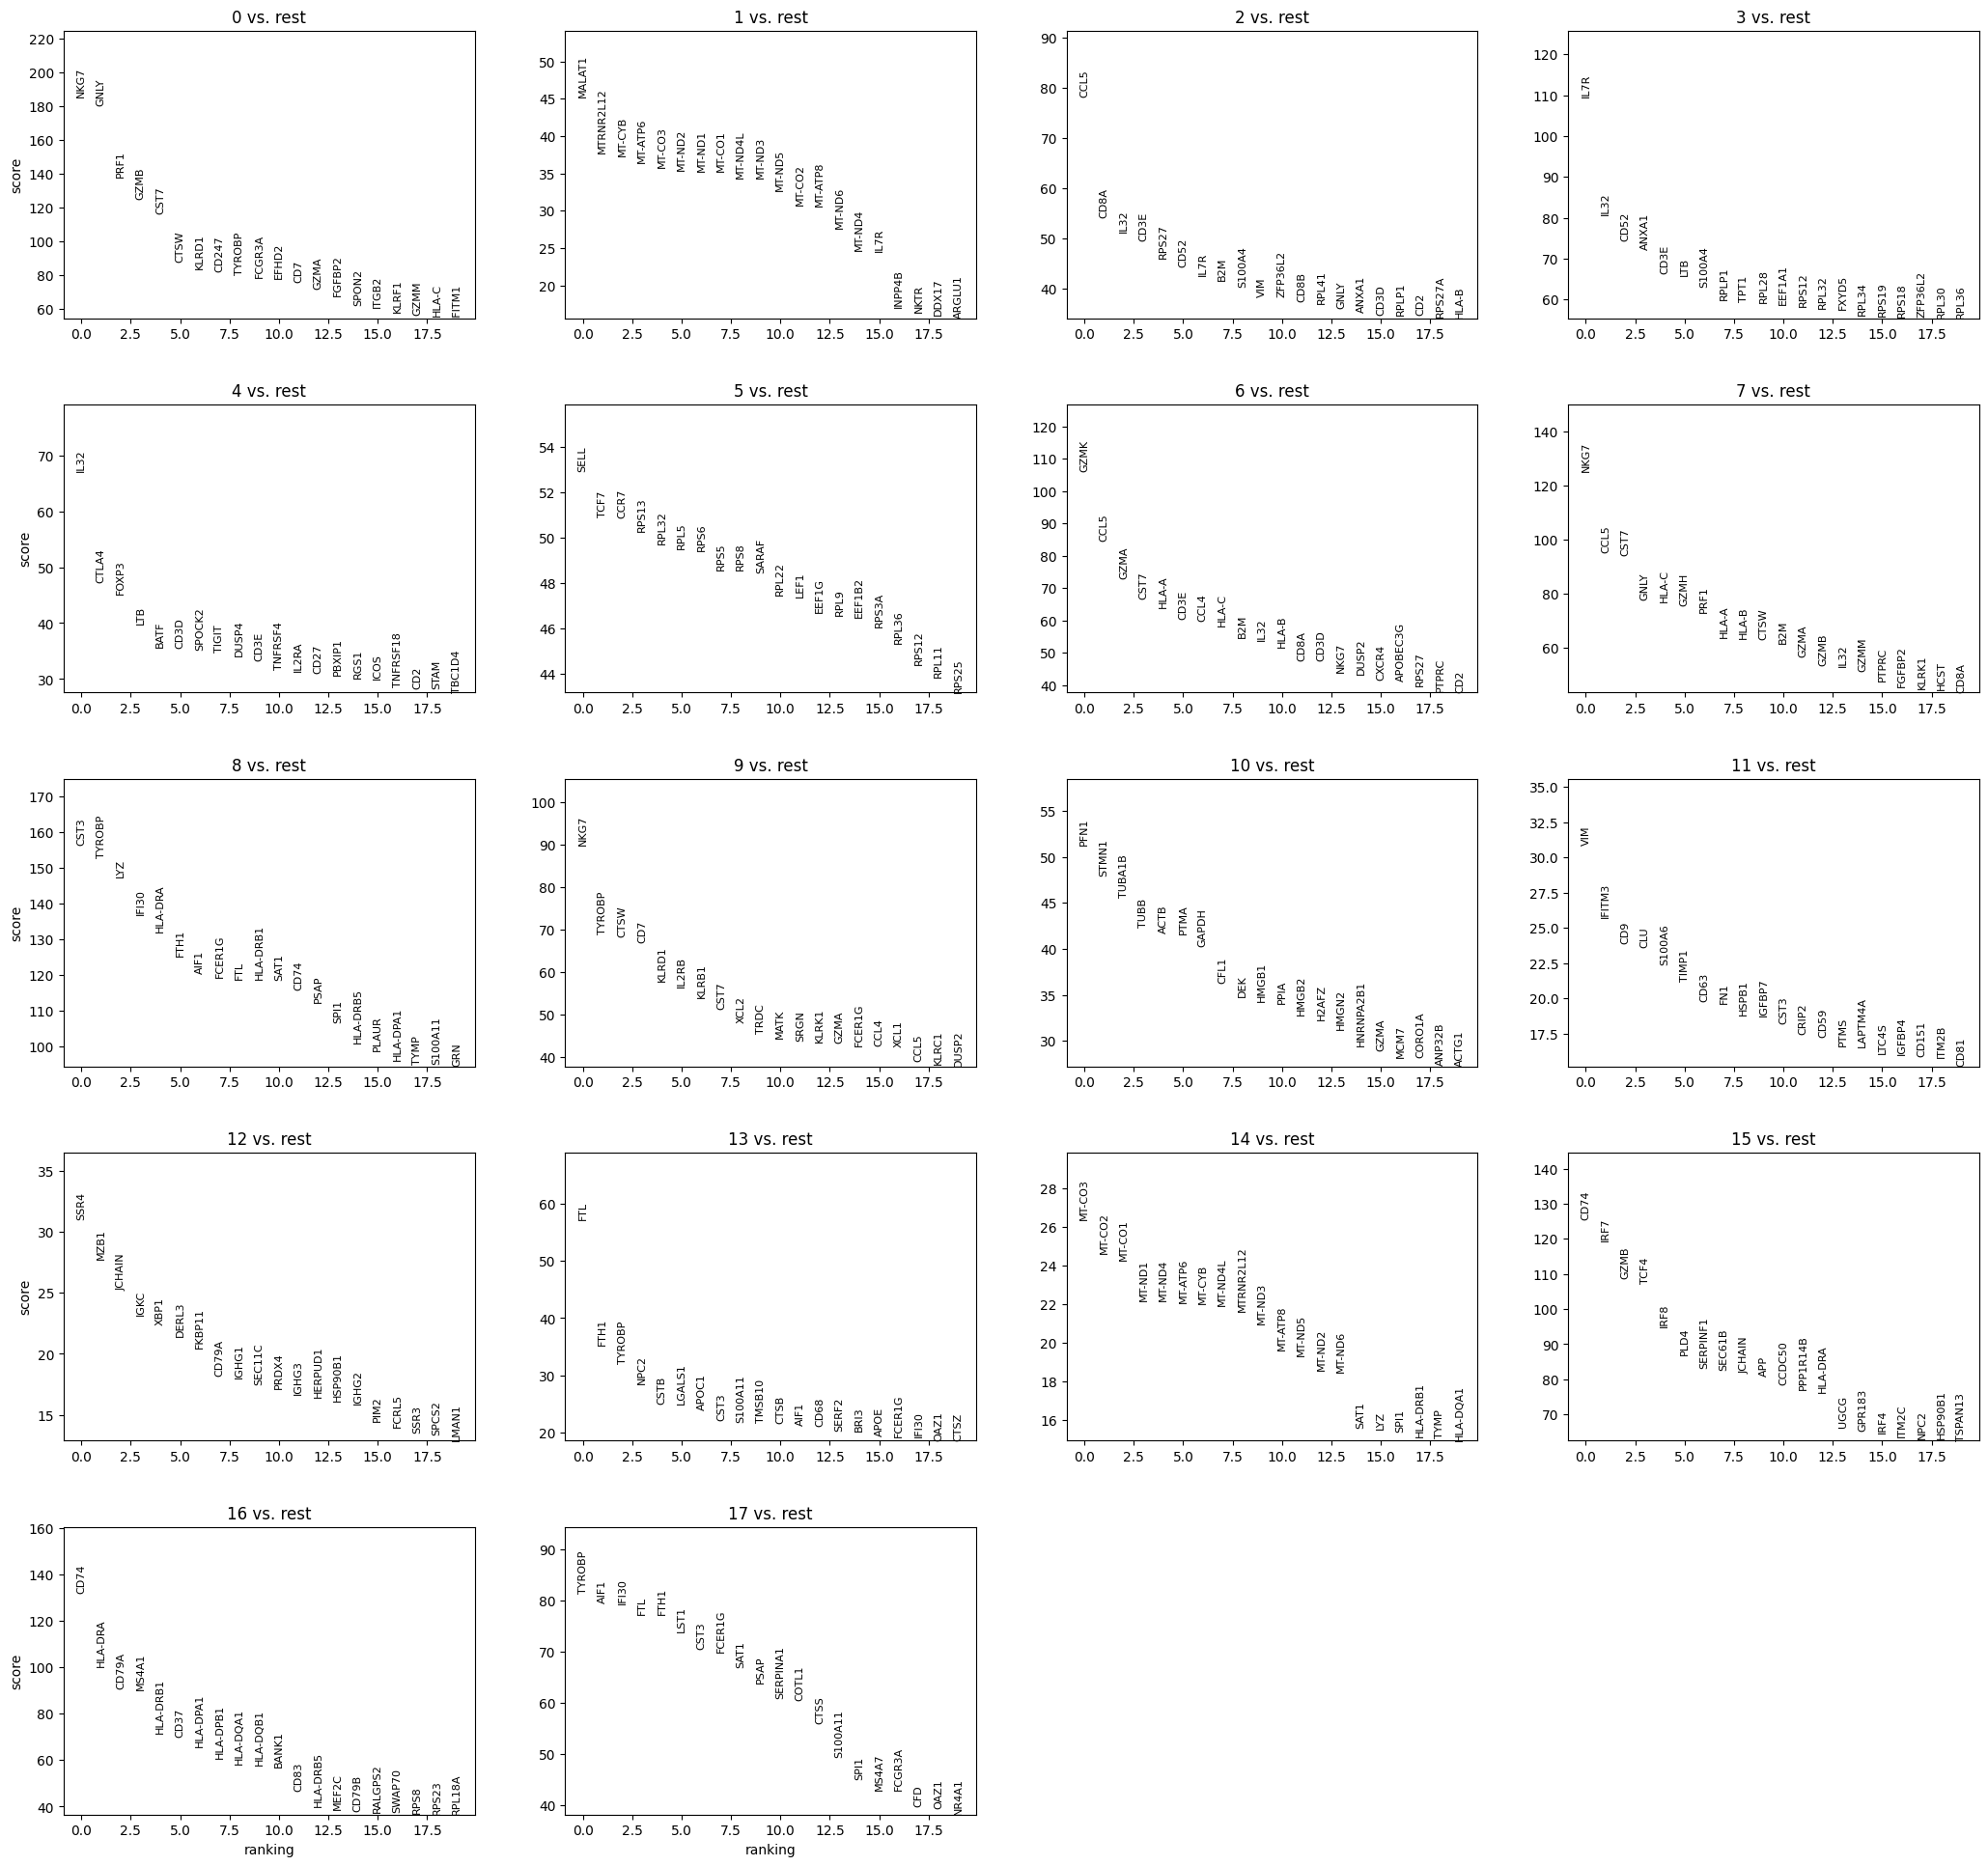

In [170]:
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

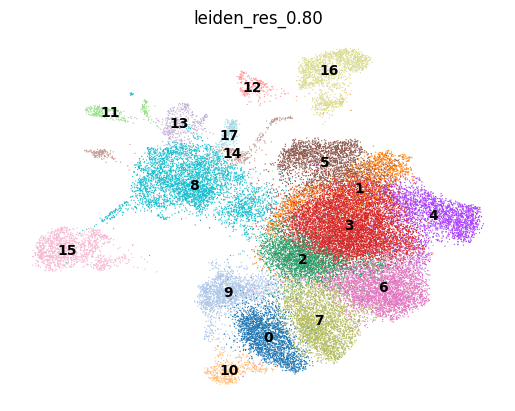

In [169]:
sc.pl.umap(adata, color = ['leiden_res_0.80'], frameon = False, legend_loc = "on data")

In [424]:
markers[markers['names'] == 'CD9']

,group,names,scores,logfoldchanges,pvals,pvals_adj
82488,8,CD9,37.481709,3.417003,4.634961e-265,7.914080e-264
113071,11,CD9,23.907743,4.999112,5.845365e-69,2.200898e-67
133719,13,CD9,9.081658,2.631939,4.740213e-18,1.381476e-17


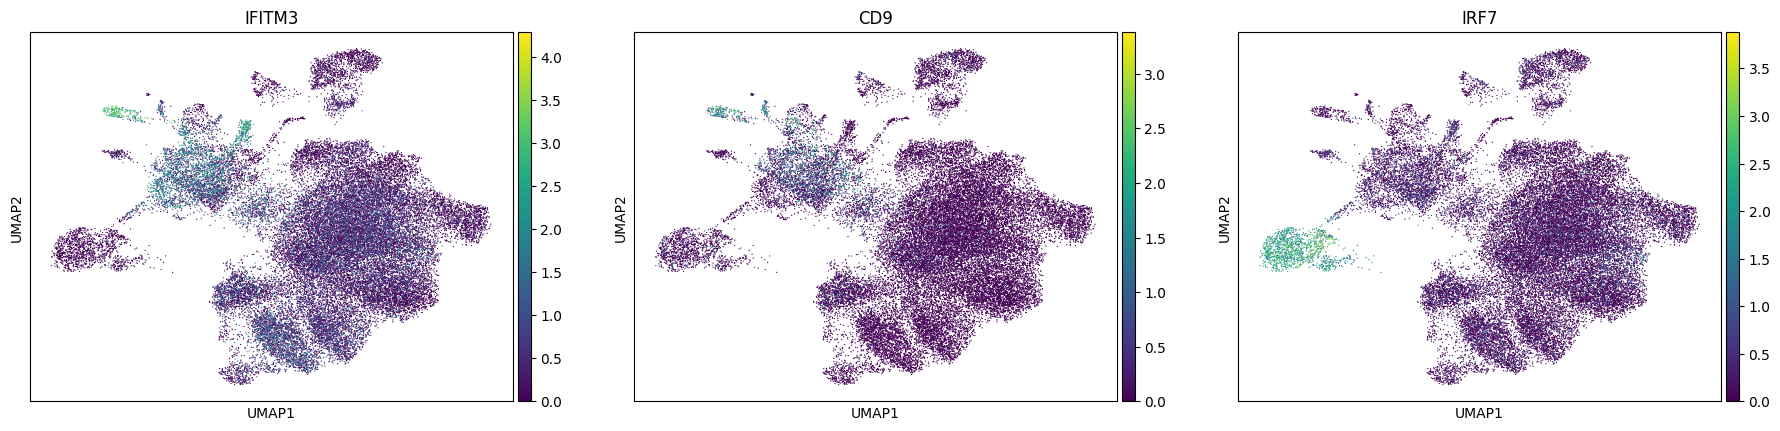

In [425]:
sc.pl.umap(adata, color = ['IFITM3', 'CD9', 'IRF7'])

In [426]:
cell_types = {
    "0":"NK cells", # CONFIDENT
    "1":"CD4+ T cells", # CONFIDENT
    "2":"CD8+ T cells", # CONFIDENT
    "3":"CD4+ T cells", # CONFIDENT
    "4":"T memory cells", # CONFIDENT
    "5":"Naive T cells", # CONFIDENT
    "6":"CD8+ T cells", # CONFIDENT
    "7":"CD8+ T cells", # Possibly NK
    "8":"Neutrophils", # CONFIDENT
    "9":"NK T cells", # CONFIDENT
    "10":"Gamma delta T cells", # CONFIDENT
    "11":"Dendritic cells", # CONFIDENT
    "12":"Plasma cells", # CONFIDENT
    "13":"Macrophages", # CONFIDENT
    "14":"Monocytes", # CONFIDENT
    "15":"Plasmacytoid dendritic cells", # CONFIDENT
    "16":"B cells", # CONFIDENT
    "17":"Monocytes" # CONFIDENT
}

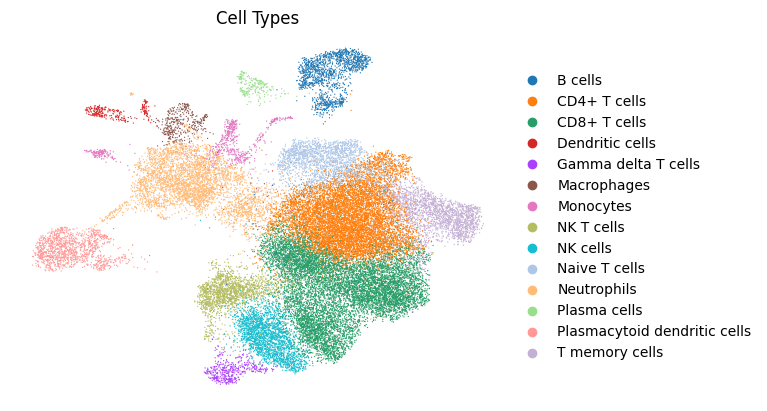

In [431]:
adata.obs['Cell Types'] = adata.obs['leiden_res_0.80'].map(cell_types)
sc.pl.umap(adata, color = ['Cell Types'], frameon = False)

In [433]:
adata.uns['scvi_markers'] = markers_scvi
adata.uns['markers'] = markers

In [434]:
adata.write_h5ad('/Users/yashasappaji/Desktop/projects/single_cell/Datasets/GSE245373_final_integrated.h5ad')
model.save('/Users/yashasappaji/Desktop/projects/single_cell/Datasets/GSE245373_model.model')